<a href="https://colab.research.google.com/github/hail-members/llm-based-services/blob/main/Chapter_11_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import TypedDict, Annotated

# 일반 dict 사용
person_dict = {
    "name": "Alice",
    "age": 25,
    "is_student": True
}
print(person_dict)
# 각각에 아무런 타입의 데이터를 넣을 수 있음
person_dict["name"] = 123  # 잘못된 타입이지만 에러가 발생하지 않음


{'name': 'Alice', 'age': 25, 'is_student': True}
{'name': 'Bob', 'age': 30, 'is_student': False}
Name: Charlie, Age: 35, Is Student: True


In [ ]:
from typing import TypedDict

# TypedDict 정의
class User(TypedDict):
    name: str
    age: int
    is_active: bool

# 올바른 사용 예
user1: User = {
    "name": "Alice",
    "age": 30,
    "is_active": True
}

# 잘못된 사용 예 (키가 누락된 경우)
user2: User = {
    "name": "Bob",
    "age": 25
}
# TypeError: Missing key 'is_active'

# 잘못된 사용 예 (잘못된 타입이 포함된 경우)
user3: User = {
    "name": "Charlie",
    "age": "thirty",  # age는 int여야 함
    "is_active": True
}
# TypeError: Expected type 'int' for key 'age', got 'str' instead



근데 위 코드블락에서는 실제로는 에러가 안납니다.

그렇지만 간단하게 mypy와 같은 타입 검사기를 썼을때 에러가 있는지 없는지 (즉, 타입이 맞는지 틀리는지) 확인할 수 있습니다.

In [ ]:
!pip install mypy

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from mypy import api

# 검사할 코드 문자열
code_to_check = """
from typing import TypedDict

class User(TypedDict):
    name: str
    age: int
    is_active: bool

# 올바른 사용 예
user1: User = {
    "name": "Alice",
    "age": 30,
    "is_active": True
}

# 잘못된 사용 예 (키가 누락된 경우)
user2: User = {
    "name": "Bob",
    "age": 25
}

# 잘못된 사용 예 (잘못된 타입이 포함된 경우)
user3: User = {
    "name": "Charlie",
    "age": "thirty",  # age는 int여야 함
    "is_active": True
}
"""

# mypy로 코드 검사
result = api.run(["-c", code_to_check, "--strict"])

# 결과 출력
print("Type Checking Output:")
print(result[0])  # mypy의 출력 결과
print("Errors:")
print(result[1])  # 에러 메시지
print("Exit Status:", result[2])  # 종료 코드 (0이면 성공, 1이면 실패)

Type Checking Output:
<string>:17: error: Missing key "is_active" for TypedDict "User"  [typeddict-item]
<string>:25: error: Incompatible types (expression has type "str", TypedDict item "age" has type "int")  [typeddict-item]
Found 2 errors in 1 file (checked 1 source file)

Errors:

Exit Status: 1


In [ ]:
from typing import Annotated, get_type_hints

class User:
    name: Annotated[str, "The name of the person"]
    age: Annotated[int, "The age of the person"]
    is_student: Annotated[bool, "Whether the person is a student"]

user: User = {
    "name": "Alice",
    "age": 30,
    "is_active": True
}

# 타입 힌트와 주석을 가져오기
hints = get_type_hints(User, include_extras=True)
print("Type Hints and Annotations:")
for attr, hint in hints.items():
    print(f"{attr}: {hint.__name__} - {hint.__metadata__[0]}")

Type Hints and Annotations:
name: Annotated - The name of the person
age: Annotated - The age of the person
is_student: Annotated - Whether the person is a student


In [ ]:
!pip install -U langgraph langchain-community gpt4all

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# 필요한 패키지 설치
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.llms import GPT4All
import random

# 1. State 정의 (messages 필드로 LLM 대화 이력 관리)
class State(TypedDict):
    graph_state: str


# 2. GPT4All(Phi-3-mini) 모델 준비
llm = GPT4All(model="Phi-3-mini-4k-instruct.Q4_0.gguf", n_threads=4, allow_download=True)

# 3. 프롬프트 템플릿 정의
prompt_template = """<|system|>
You are a helpful assistant.<|end|>
<|user|>
{question}<|end|>
<|assistant|>
"""


In [ ]:
# 4. 각 노드 정의 (각 노드에서 LLM 호출)
def node_1(state: State):
    print("---Node 1---")
    context = ""
    question = state['graph_state'] + " I am"
    prompt = prompt_template.format(context=context, question=question)
    response = llm.invoke(prompt)
    return {"graph_state": response.strip()}

def node_2(state: State):
    print("---Node 2---")
    context = ""
    question = state['graph_state'] + " happy!"
    prompt = prompt_template.format(context=context, question=question)
    response = llm.invoke(prompt)
    return {"graph_state": response.strip()}

def node_3(state: State):
    print("---Node 3---")
    context = ""
    question = state['graph_state'] + " sad!"
    prompt = prompt_template.format(context=context, question=question)
    response = llm.invoke(prompt)
    return {"graph_state": response.strip()}

# 5. 조건부 분기 함수
from typing import Literal
def decide_mood(state) -> Literal["node_2", "node_3"]:
    # 50% 확률로 node_2 또는 node_3 선택
    if random.random() < 0.5:
        return "node_2"
    return "node_3"



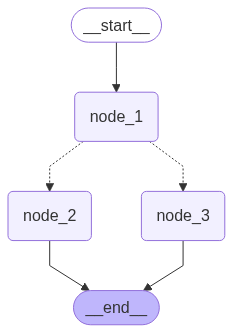

In [ ]:
from IPython.display import Image, display

# 6. 그래프 구성 및 컴파일
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

# 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 7. 그래프 실행
initial_state = {"graph_state": "Hi, this is Lance."}
result = graph.invoke(initial_state)
print("\n최종 결과:")
print(result["graph_state"])

---Node 1---
---Node 2---

최종 결과:
Hello there! I hope you're doing well today. As your virtual assistant, I am here to help answer any questions or address concerns you may have in various areas such as general knowledge, technology-related queries, daily tips and tricks, productivity advice, travel recommendations, cooking recipes, fitness guidance, etc.

For example:
1. If you're looking for a new workout routine to stay healthy or lose weight - I can provide exercise suggestions tailored specifically to your needs!
2. Need help with organizing tasks and managing time more efficiently? Let me share some productivity hacks that might be useful in streamlining your daily activities.
3. If you're planning a trip, whether it's for business or leisure purposes - I can offer travel tips to make the most out of your experience!
4. Looking for new recipes? Whether you have dietary restrictions (e.g., vegan, gluten-free) or just want something delicious and easy to prepare – let me help with 

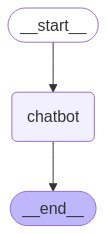

첫 번째 실행 결과:
{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': " Hello! Yes, it sounds like you're experiencing some rain outside. Rainy days can be cozy and perfect for indoor activities or catching up on your favorite books or movies. If there's anything specific you need help with during this weather, feel free to ask!"}]}

두 번째 실행 전 상태:
{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': " Hello! Yes, it sounds like you're experiencing some rain outside. Rainy days can be cozy and perfect for indoor activities or catching up on your favorite books or movies. If there's anything specific you need help with during this weather, feel free to ask!"}, {'role': 'user', 'content': 'How is the weather?'}]}

두 번째 실행 결과:
{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': " Hello! Yes, it sounds like you're experiencing some rain outside. Rain

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.llms import GPT4All

# 1. State 정의
class State(TypedDict):
    messages: list

# 2. 모델 준비
llm = GPT4All(model="Phi-3-mini-4k-instruct.Q4_0.gguf", n_threads=4, allow_download=True)

# 3. 프롬프트 템플릿
prompt_template = """<|system|>
You are a helpful assistant.<|end|>
<|user|>
{question}<|end|>
<|assistant|>
"""

# 4. 챗봇 노드 (이전 메시지 이력 누적)
def chatbot(state: State):
    # 마지막 user 메시지 추출
    last_user_msg = state["messages"][-1]["content"]
    prompt = prompt_template.format(question=last_user_msg)
    response = llm.invoke(prompt)
    # 이전 메시지 + assistant 응답 누적
    return {"messages": state["messages"] + [{"role": "assistant", "content": response}]}

# 5. 그래프 빌더 및 연결
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 6. MemorySaver로 컴파일
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)
display(Image(react_graph_memory.get_graph().draw_mermaid_png()))

# # 7. 첫 번째 실행 (user 메시지로 시작)
config = {"configurable": {"thread_id": "1"}}
init_state = {"messages": [{"role": "user", "content": "Hello, today is rainy."}]}
result1 = react_graph_memory.invoke(init_state, config)
print("첫 번째 실행 결과:")
print(result1)

# 8. 두 번째 실행 (이전 결과의 messages를 그대로 사용, user 메시지만 추가)
next_state = {"messages": result1["messages"] + [{"role": "user", "content": "How is the weather?"}]}
print("\n두 번째 실행 전 상태:")
print(next_state)
result2 = react_graph_memory.invoke(next_state, config)
print("\n두 번째 실행 결과:")
print(result2)


In [ ]:
print("\nMemorySaver에 저장된 전체 상태:")
memory.get(config)


MemorySaver에 저장된 전체 상태:


{'v': 3,
 'ts': '2025-05-20T15:00:46.885544+00:00',
 'id': '1f0358b3-5dc8-6297-8004-e1cff3ce755d',
 'channel_versions': {'__start__': '00000000000000000000000000000005.0.7418348662138593',
  'messages': '00000000000000000000000000000006.0.18352347132433733',
  'branch:to:chatbot': '00000000000000000000000000000006.0.3746154133250228'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000004.0.651131853121127'},
  'chatbot': {'branch:to:chatbot': '00000000000000000000000000000005.0.37533055036843566'}},
 'channel_values': {'messages': [{'role': 'user',
    'content': 'Hello, today is rainy.'},
   {'role': 'assistant',
    'content': " Hello! Yes, it sounds like you're experiencing some rain outside. Rainy days can be cozy and perfect for indoor activities or catching up on your favorite books or movies. If there's anything specific you need help with during this weather, feel free to ask!"},
   {'role': 'user', 'content': 'How is the weather?'}

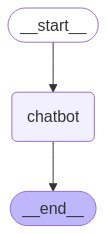

첫 번째 실행 결과:
{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}]}

두 번째 실행 전 상태:
{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}, {'role': 'user', 'content': 'How i

In [ ]:
prompt_template = """<|system|>
You are a helpful assistant.<|end|>
<|user|>
{context} {question}<|end|>
<|assistant|>
"""

# 4. 챗봇 노드 (이전 메시지 이력 누적)
def chatbot(state: State):
    # 마지막 user 메시지 추출
    last_user_msg = state["messages"][-1]["content"]
    # 기존 대화 기록을 포함한 프롬프트 생성
    context = "\n".join([f"{msg['role']}: {msg['content']}" for msg in state["messages"]])
    prompt = prompt_template.format(context=context, question=last_user_msg)
    response = llm.invoke(prompt)
    # 이전 메시지 + assistant 응답 누적
    return {"messages": state["messages"] + [{"role": "assistant", "content": response}]}

# 5. 그래프 빌더 및 연결
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 6. MemorySaver로 컴파일
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)
display(Image(react_graph_memory.get_graph().draw_mermaid_png()))

# # 7. 첫 번째 실행 (user 메시지로 시작)
config = {"configurable": {"thread_id": "1"}}
init_state = {"messages": [{"role": "user", "content": "Hello, today is rainy."}]}
result1 = react_graph_memory.invoke(init_state, config)
print("첫 번째 실행 결과:")
print(result1)

# 8. 두 번째 실행 (이전 결과의 messages를 그대로 사용, user 메시지만 추가)
next_state = {"messages": result1["messages"] + [{"role": "user", "content": "How is the weather?"}]}
print("\n두 번째 실행 전 상태:")
print(next_state)
result2 = react_graph_memory.invoke(next_state, config)
print("\n두 번째 실행 결과:")
print(result2)

In [ ]:
checkpoints = list(react_graph_memory.get_state_history(config))
print(f"총 체크포인트 개수: {len(checkpoints)}")
for i, cp in enumerate(checkpoints):
    print(f"체크포인트 {i}: {cp.values}")

총 체크포인트 개수: 6
체크포인트 0: {'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}, {'role': 'user', 'content': 'How is the weather?'}, {'role': 'assistant', 'content': " The current weather conditions are quite typical for a rainy day - cloudy skies and gentle rain showers throughout most of the area. It's always good to check your local forecast or use a reliable weather app if you want more specific information about temperature, humidity levels, wind speed, etc., in real-time!"}]}
체크포인트 1: {'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'c

In [ ]:
rollback_state = checkpoints[3].values  # 롤백
react_graph_memory.update_state(config, rollback_state)

{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}]}


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0358ea-d677-63e0-8005-d41d9e32f2b9'}}

In [ ]:
rollback_state

{'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'},
  {'role': 'assistant',
   'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}]}

In [ ]:
# 8. 롤백 후 이어서 실행
result_rollback = react_graph_memory.invoke({"messages": rollback_state["messages"] +  [{"role": "user", "content": "How is the weather?"}]}, config)
print("롤백 후 실행 결과:", result_rollback)

롤백 후 실행 결과: {'messages': [{'role': 'user', 'content': 'Hello, today is rainy.'}, {'role': 'assistant', 'content': ' Hello! I can certainly understand that the rain might affect your day. Rainy days have their own charm and beauty too - they provide an opportunity to enjoy indoor activities or simply relax with a warm cup of tea while listening to the soothing sound of raindrops outside. If you need any suggestions for things to do on this cozy, rainy day, feel free to ask!'}, {'role': 'user', 'content': 'How is the weather?'}, {'role': 'assistant', 'content': " The current weather conditions are quite typical for a rainy day - cloudy skies and gentle rain showers throughout most of the area. It's always good to check your local forecast or use a reliable weather app if you want more specific information about temperature, humidity levels, wind speed, etc., in real-time!"}]}
